In [16]:
# Holy shit it worked.

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import astropy.io.fits as fits
import glob
from lsst.sims.photUtils import Sed, Bandpass
import os

In [2]:
# Grab the current directory
cwd = os.getcwd()
# just one dir to start
directory = os.path.join(cwd, 'ckm05')
filepath = glob.glob(os.path.join(directory,'*.fits'))

# Test spectra:
hdul = fits.open(filepath[-11])
header = hdul[0].header.copy()
spec_table = hdul[1].data.copy()
hdul.close()

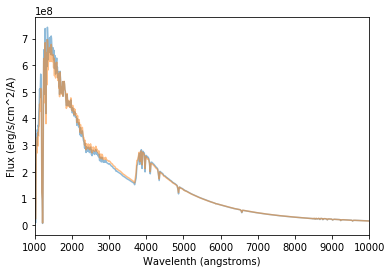

In [14]:
# Let's see what a few of them look like
plt.plot(spec_table['WAVELENGTH'], spec_table['g30'], alpha=0.5)
plt.plot(spec_table['WAVELENGTH'], spec_table['g25'], alpha=.5)
# Always always keep track of units!
plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000]);

# UGRIZY:

In [35]:
band_dir = os.getenv("LSST_THROUGHPUTS_BASELINE")

filterlist =['u', 'g', 'r', 'i', 'z', 'y']
bps = []

for filtername in filterlist:
    
    tempB = Bandpass()
    tempB.readThroughput(band_dir+'filter_'+filtername+'.dat')
    bps.append(tempB)

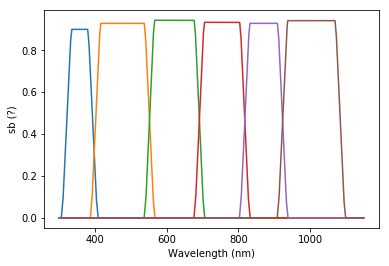

In [36]:
# Plotting broad band filter bands:

for bp in bps:
    plt.plot(bp.wavelen, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

# SPLUS Survey Narrowband Filters:

In [29]:
splus_filt_dir = os.path.join(cwd, 'splus_filter_curves/')

In [30]:
narrowbandfiltlist = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

splus_narrowbands = []

# Only problem with getting the splus survey narrowbands to fit into the Bandpass object was
# that I needed to specify a max and min wavelength for some reason. Once they were explicitly
# defined, however, it went pretty smoothly.

for filtername in narrowbandfiltlist:
    
    tempB2 = Bandpass(wavelen_min=3000, wavelen_max=9000)
    tempB2.readThroughput(splus_filt_dir+filtername+'.dat')
    splus_narrowbands.append(tempB2)

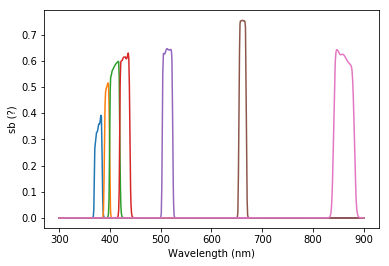

In [31]:
# plotting again to make sure they've come out right

for bp in splus_narrowbands:
    plt.plot(bp.wavelen/10, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

# Experimentation:

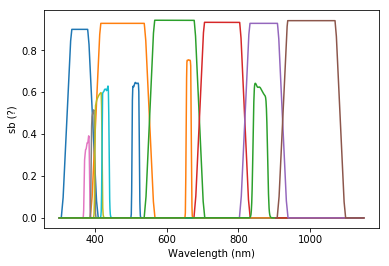

In [37]:
# Narrow & broad band group shot:

for bp in bps:
    plt.plot(bp.wavelen, bp.sb)
for nbp in splus_narrowbands:
    plt.plot(nbp.wavelen/10, nbp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

In [53]:
plt.style.use('ggplot')

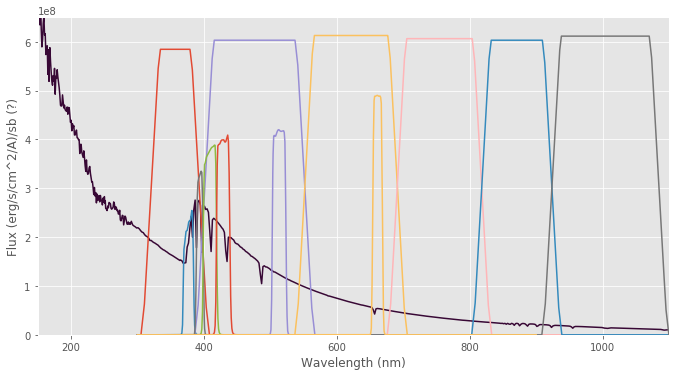

In [54]:
# y-axis is a mess here, but wanted one of the spectra and the filter bands overlaid

fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(9.5,5)                  

fig.tight_layout()                          

ax.set_xlim(150,1100)
ax.set_ylim(0,6.5*10**8)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux (erg/s/cm^2/A)/sb (?)")

ax.plot(spec_table['WAVELENGTH']/10, spec_table['g40'], alpha=1.0, color='xkcd:eggplant')
for bp, nbp in zip(bps, splus_narrowbands):
    ax.plot(bp.wavelen, bp.sb*6.5*10**8, nbp.wavelen/10, nbp.sb*6.5*10**8);

# Putting the Bits Together:

In [47]:
# Success!

spectra_directory_keys = ['ckm05', 'ckm10', 'ckm15', 'ckm20', 'ckm25', 'ckp00', 'ckp02', 'ckp05']
gravity_keys = ['g00', 'g05', 'g10', 'g15', 'g20', 'g25', 'g30', 'g35', 'g40', 'g45', 'g50']
list_list =[]

for spectra_directory in spectra_directory_keys:
    directory = os.path.join(cwd, spectra_directory)
    filepath = glob.glob(os.path.join(directory,'*.fits'))
    
    for filename in filepath:
    
        hdul2 = fits.open(filename)
        header1 = hdul2[0].header.copy()
        spec_table1 = hdul2[1].data.copy()

        for grav in gravity_keys:
            
            # order will be filename, Teff, Fe/H, logg, various magnitudes
            star_properties = []
            #star_properties.append(os.path.basename(filename))
            teff = header1['TEFF']
            hella_metal = header1['LOG_Z']
            star_properties.append(np.float64(teff))
            star_properties.append(hella_metal)
            my_seds = Sed(wavelen=spec_table1['WAVELENGTH']/10, flambda=spec_table1[grav]*10)
            star_properties.append(np.float64(grav[1:]))

            for bp in splus_narrowbands:

                flux = my_seds.calcFlux(bp)

                if flux > 0:
                    nb_mag = my_seds.calcMag(bp)
                    star_properties.append(nb_mag)
                else:
                    star_properties.append(np.nan)
                    
            for bbp in bps:
                
                flux1 = my_seds.calcFlux(bbp)
                if flux1 > 0:
                    bb_mag = my_seds.calcMag(bbp)
                    star_properties.append(bb_mag)
            # Only add to the large arary if there were broad band fluxes
            if len(star_properties) > 4+len(splus_narrowbands) + 3:
                list_list.append(star_properties)
            
hdul2.close()

In [48]:
list_list[0:20]

[[4500.0,
  -0.5,
  0.0,
  -36.759173118866244,
  -36.67754745082098,
  -36.60231895637821,
  -36.461830784777874,
  -35.98928243416195,
  -35.62842944806256,
  -35.077666593454126,
  -33.393418879758386,
  -36.26345550734443,
  -37.28278396360717,
  -37.60873741247926,
  -37.7533001861252,
  -37.883438343344096],
 [4500.0,
  -0.5,
  5.0,
  -36.75301121977624,
  -36.67112278665887,
  -36.595986143692556,
  -36.45810153826645,
  -35.996745777458045,
  -35.62237873233762,
  -35.07420168347976,
  -33.630599388028244,
  -36.31710070662869,
  -37.27968823187011,
  -37.59212495562578,
  -37.73715900651165,
  -37.86365330822156],
 [4500.0,
  -0.5,
  10.0,
  -36.74791316876875,
  -36.665739826600046,
  -36.59083362871627,
  -36.45545727297174,
  -36.00553414775102,
  -35.61797842937976,
  -35.071572421194915,
  -33.83040458227269,
  -36.35175480300941,
  -37.273659214538924,
  -37.57955099054384,
  -37.72551358147193,
  -37.84955012523376],
 [4500.0,
  -0.5,
  15.0,
  -36.743687773654926,
  -3

In [49]:
# Let's save it as a numpy zip file so we can load it later
column_names = ['Teff', 'log_Z', 'gravity']
column_names.extend(narrowbandfiltlist)
column_names.extend(filterlist)
dtypes = [np.float64]*len(column_names)

In [50]:
# final arary 
temp_array = np.array(list_list)
model_atm_mags = np.zeros(temp_array.shape[0], dtype=list(zip(column_names, dtypes)))
# This is horrible and ugly, but I'm getting some weird dtype error.
for i,key in enumerate(model_atm_mags.dtype.names):
    model_atm_mags[key] += temp_array[:,i]

In [51]:
# Save the big handy array
np.savez('model_atm_mags.npz', model_atm_mags=model_atm_mags)

# Model spectra library, visualized:

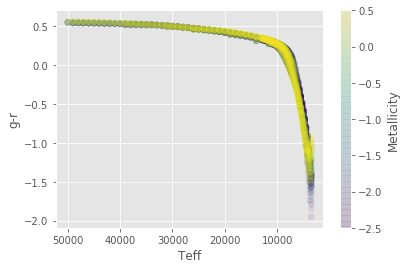

In [55]:
plt.scatter(model_atm_mags['Teff'], model_atm_mags['r']-model_atm_mags['g'],  c=model_atm_mags['log_Z'], alpha=.1)
cb = plt.colorbar()
cb.set_label('Metallicity')
plt.gca().invert_xaxis()
plt.xlabel('Teff')
plt.ylabel('g-r');

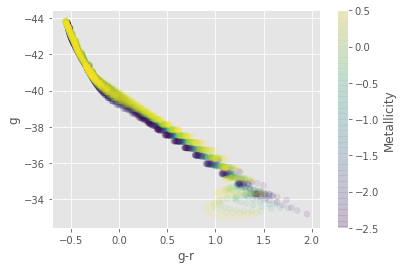

In [56]:
# Let's make a CMD
plt.scatter(model_atm_mags['g']-model_atm_mags['r'],model_atm_mags['g'],  c=model_atm_mags['log_Z'], alpha=.1)
cb = plt.colorbar()
cb.set_label('Metallicity')
plt.gca().invert_yaxis()
plt.xlabel('g-r')
plt.ylabel('g');

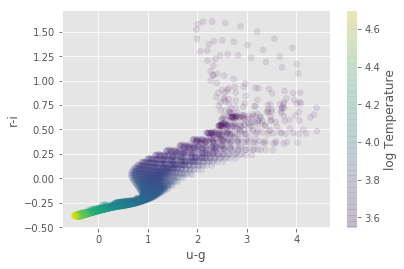

In [57]:

plt.scatter(model_atm_mags['u']-model_atm_mags['g'],model_atm_mags['r']-model_atm_mags['i'],
            c=np.log10(model_atm_mags['Teff']), alpha=.1)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.xlabel('u-g')
plt.ylabel('r-i');